# Fitting censored data

Experimental measurements are sometimes censored such that we only know partial information about a particular data point. For example, in measuring the lifespan of mice, a portion of them might live through the duration of the study, in which case we only know the lower bound.

One of the ways we can deal with this is to use Maximum Likelihood Estimation ([MLE](http://en.wikipedia.org/wiki/Maximum_likelihood)). However, censoring often make analytical solutions difficult even for well known distributions.

We can overcome this challenge by converting the MLE into a convex optimization problem and solving it using [CVXPY](http://www.cvxpy.org/en/latest/).

This example is adapted from a homework problem from Boyd's [CVX 101: Convex Optimization Course](https://class.stanford.edu/courses/Engineering/CVX101/Winter2014/info).


## Setup

We will use similar notation here. Suppose we have a linear model:

$$ y^{(i)} = c^Tx^{(i)} +\epsilon^{(i)} $$

where $y^{(i)} \in \mathbf{R}$, $c \in \mathbf{R}^n$, $k^{(i)} \in \mathbf{R}^n$, and $\epsilon^{(i)}$ is the error and has a normal distribution $N(0, \sigma^2)$ for $ i = 1,\ldots,K$.

Then the MLE estimator $c$ is the vector that minimizes the sum of squares of the errors $\epsilon^{(i)}$, namely:

$$
\begin{array}{ll}
  \underset{c}{\text{minimize}} & \sum_{i=1}^K (y^{(i)} - c^T x^{(i)})^2
\end{array}
$$

In the case of right censored data, only $M$ observations are fully observed and all that is known for the remaining observations is that $y^{(i)} \geq D$ for $i=\text{M+1},\ldots,K$ and some constant $D$.

Now let's see how this would work in practice.


## Data Generation

In [1]:
import numpy as np
n = 30 # number of variables
M = 50 # number of censored observations
K = 200 # total number of observations

np.random.seed(n*M*K)
X = np.random.randn(K*n).reshape(K, n)
c_true = np.random.rand(n)

# generating the y variable
y = X.dot(c_true) + .3*np.sqrt(n)*np.random.randn(K)

# ordering them based on y
order = np.argsort(y)
y_ordered = y[order]
X_ordered = X[order,:]

#finding boundary
D = (y_ordered[M-1] + y_ordered[M])/2. 

# applying censoring
y_censored = np.concatenate((y_ordered[:M], np.ones(K-M)*D))

import matplotlib.pyplot as plt

# Show plot inline in ipython.
%matplotlib inline

def plot_fit(fit, fit_label):
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(y_censored, 'bo', label = 'censored data')
    plt.plot(y_ordered, 'co', label = 'uncensored data')
    plt.plot(fit, 'ro', label=fit_label)
    plt.ylabel('y')
    plt.legend(loc=0)
    plt.xlabel('observations');


## Regular OLS

Let's see what the OLS result looks like. We'll use the `np.linalg.lstsq` function to solve for our coefficients.

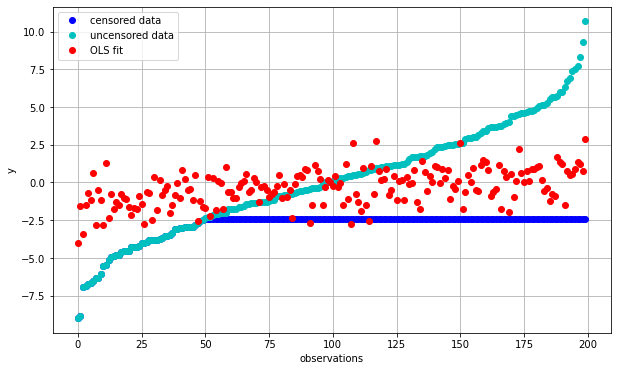

In [2]:
c_ols = np.linalg.lstsq(X_ordered, y_censored, rcond=None)[0]
fit_ols = X_ordered.dot(c_ols)
plot_fit(fit_ols, 'OLS fit')

We can see that we are systematically overestimating low values of $y$ and vice versa (red vs. cyan). This is caused by our use of censored (blue) observations, which are exerting a lot of leverage and pulling down the trendline to reduce the error between the red and blue points.

## OLS using uncensored data

A simple way to deal with this while maintaining analytical tractability is to simply ignore all censored observations. 

$$
\begin{array}{ll}
  \underset{c}{\text{minimize}} & \sum_{i=1}^M (y^{(i)} - c^T x^{(i)})^2
\end{array}
$$

Give that our $M$ is much smaller than  $K$, we are  throwing away the majority of the dataset in order to accomplish this, let's see how this new regression does.

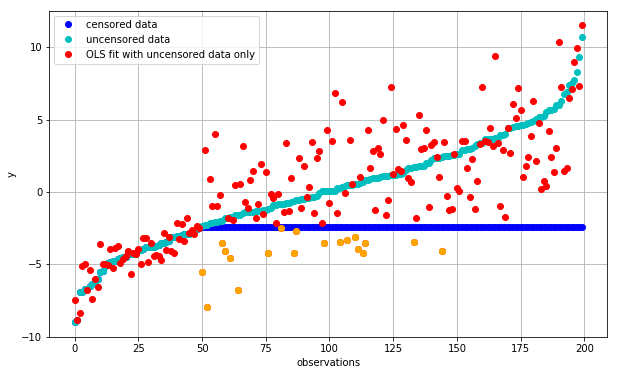

In [3]:
c_ols_uncensored = np.linalg.lstsq(X_ordered[:M], y_censored[:M], rcond=None)[0]
fit_ols_uncensored = X_ordered.dot(c_ols_uncensored)
plot_fit(fit_ols_uncensored, 'OLS fit with uncensored data only')

bad_predictions = (fit_ols_uncensored<=D) & (np.arange(K)>=M)
plt.plot(np.arange(K)[bad_predictions], fit_ols_uncensored[bad_predictions], color='orange', marker='o', lw=0);

We can see that the fit for the uncensored portion is now vastly improved. Even the fit for the censored data is now relatively unbiased i.e. the fitted values (red points) are now centered around the uncensored obsevations (cyan points).

The one glaring issue with this arrangement is that we are now predicting many observations to be _below_ $D$ (orange) even though we are well aware that this is not the case. Let's try to fix this.

##Using constraints to take into account of censored data
Instead of throwing away all censored observations, lets leverage these observations to enforce the additional information that we know, namely that $y$ is bounded from below. We can do this by setting additional constraints:

$$
\begin{array}{ll}
  \underset{c}{\text{minimize}} & \sum_{i=1}^M (y^{(i)} - c^T x^{(i)})^2 \\
  \text{subject to} & c^T x^{(i)} \geq D\\
  & \text{for } i=\text{M+1},\ldots,K
\end{array}
$$


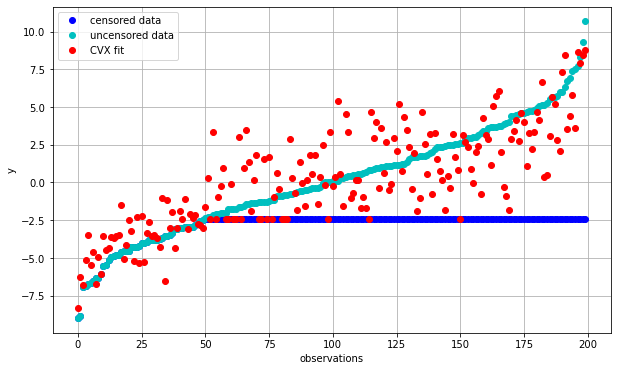

In [4]:
import cvxpy as cp
X_uncensored = X_ordered[:M, :]
c = cp.Variable(shape=n)
objective = cp.Minimize(cp.sum_squares(X_uncensored @ c - y_ordered[:M]))
constraints = [ X_ordered[M:,:] @ c >= D]
prob = cp.Problem(objective, constraints)
result = prob.solve()

c_cvx = np.array(c.value).flatten()
fit_cvx = X_ordered.dot(c_cvx)
plot_fit(fit_cvx, 'CVX fit')

Qualitatively, this already looks better than before as it no longer predicts inconsistent values with respect to the censored portion of the data. But does it do a good job of actually finding coefficients $c$ that are close to our original data?

We'll use a simple Euclidean distance $\|c_\text{true} - c\|_2$ to compare:

In [5]:
print("norm(c_true - c_cvx): {:.2f}".format(np.linalg.norm((c_true - c_cvx))))
print("norm(c_true - c_ols_uncensored): {:.2f}".format(np.linalg.norm((c_true - c_ols_uncensored))))

norm(c_true - c_cvx): 1.49
norm(c_true - c_ols_uncensored): 2.23


## Conclusion
Fitting censored data to a parametric distribution can be challenging as the MLE solution is often not analytically tractable. However, many MLEs can be converted into a convex optimization problems as show above. With the advent of simple-to-use and robust numerical packages, we can now solve these problems easily while taking into account the entirety of our information set by enforcing consistency conditions on various portions of the data.